In [ ]:
import json
import glob

path = r"C:\V89\data\*_annotation.json"

event_types = set()

for file in glob.glob(path):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        for event in data.get("events", []):
            event_types.add(event["event_type"])

print("Class ที่พบใน dataset:", event_types)


Class ที่พบใน dataset: {'osa', 'hypo'}


# Process Data

In [ ]:
from osa_data_only_phone import OSAData

data_path = r"C:\V89\data"
processor = OSAData(data_path)
processor.load_data()

print(f"Loaded {len(processor.patient_audio)} patients")

wav_data_1, sr_1 = processor.patient_audio[0]
print(wav_data_1.shape)       # (จำนวน samples,)
print(sr_1)                   # เช่น 48000
# Now you can use processor.patient_audio, processor.patient_annotations, etc.

Found phone files: ['C:\\V89\\data\\01_phone.wav', 'C:\\V89\\data\\02_phone.wav', 'C:\\V89\\data\\03_phone.wav', 'C:\\V89\\data\\04_phone.wav', 'C:\\V89\\data\\05_phone.wav', 'C:\\V89\\data\\06_phone.wav', 'C:\\V89\\data\\07_phone.wav', 'C:\\V89\\data\\08_phone.wav', 'C:\\V89\\data\\09_phone.wav', 'C:\\V89\\data\\10_phone.wav', 'C:\\V89\\data\\12_phone.wav', 'C:\\V89\\data\\13_phone.wav', 'C:\\V89\\data\\14_phone.wav', 'C:\\V89\\data\\15_phone.wav', 'C:\\V89\\data\\16_phone.wav', 'C:\\V89\\data\\18_phone.wav', 'C:\\V89\\data\\19_phone.wav', 'C:\\V89\\data\\20_phone.wav']
Found annotation files: ['C:\\V89\\data\\01_annotation.json', 'C:\\V89\\data\\02_annotation.json', 'C:\\V89\\data\\03_annotation.json', 'C:\\V89\\data\\04_annotation.json', 'C:\\V89\\data\\05_annotation.json', 'C:\\V89\\data\\06_annotation.json', 'C:\\V89\\data\\07_annotation.json', 'C:\\V89\\data\\08_annotation.json', 'C:\\V89\\data\\09_annotation.json', 'C:\\V89\\data\\10_annotation.json', 'C:\\V89\\data\\12_annotati

# Global Event Count

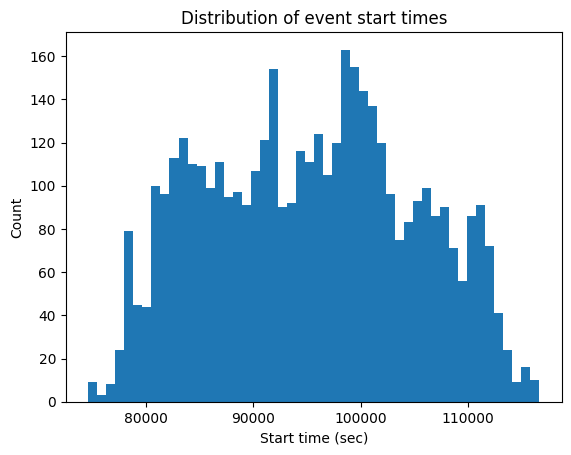

In [3]:
import matplotlib.pyplot as plt

start_times = [e["evnet_start"] for ann in processor.patient_annotations for e in ann["events"]]
plt.hist(start_times, bins=50)
plt.xlabel("Start time (sec)")
plt.ylabel("Count")
plt.title("Distribution of event start times")
plt.show()


### Each Class avg duration

In [4]:
from collections import Counter
import numpy as np
event_counter = Counter()
durations_hypo, durations_osa = [], []

for ann in processor.patient_annotations:
    for e in ann["events"]:
        event_counter[e["event_type"]] += 1
        if e["event_type"] == "hypo":
            durations_hypo.append(e["event_duration"])
        elif e["event_type"] == "osa":
            durations_osa.append(e["event_duration"])

print(event_counter)
print(f"Hypo avg duration: {np.mean(durations_hypo):.2f}s")
print(f"OSA avg duration: {np.mean(durations_osa):.2f}s")


Counter({'hypo': 2676, 'osa': 1636})
Hypo avg duration: 25.09s
OSA avg duration: 27.12s


# Example Low and High density

Max bin: (('05', 118), 3) Min bin: (('01', 107), 1)

=== High density segment ===


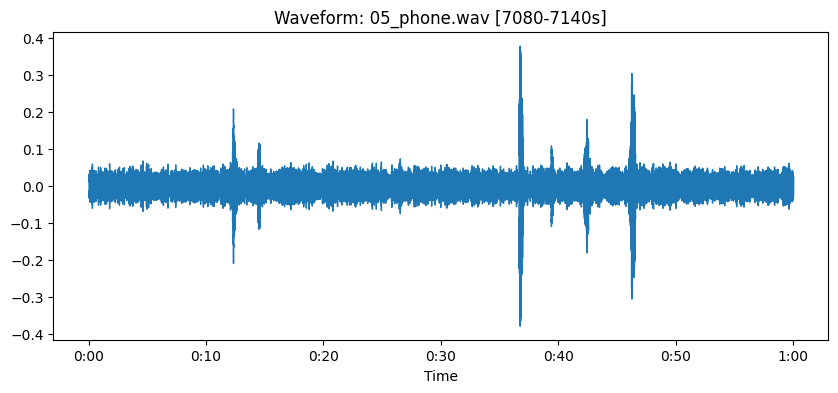

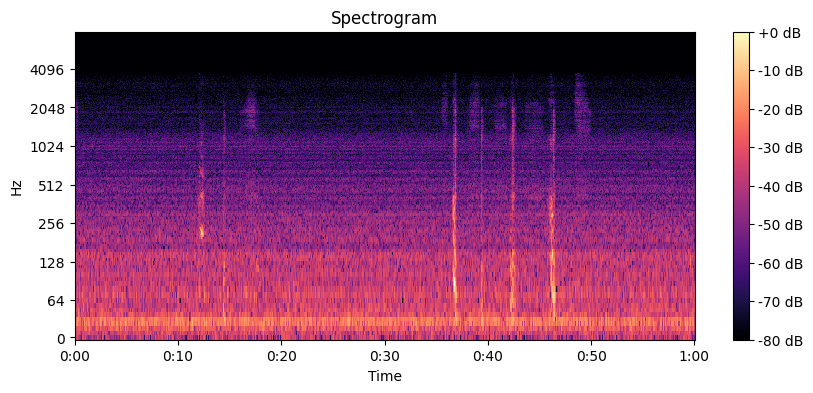


=== Low density segment ===


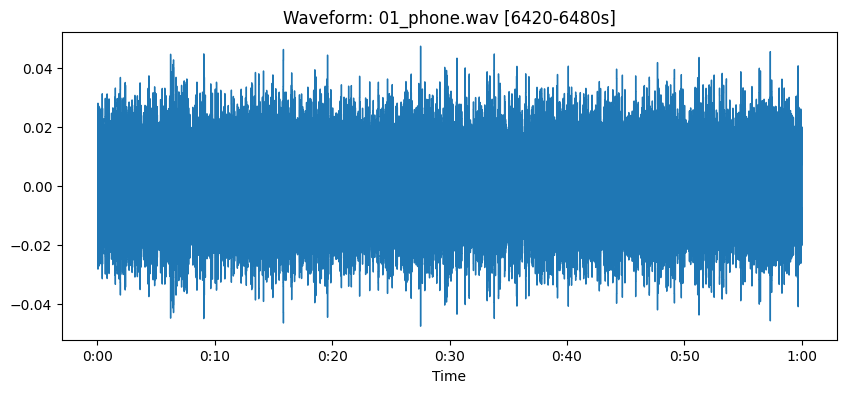

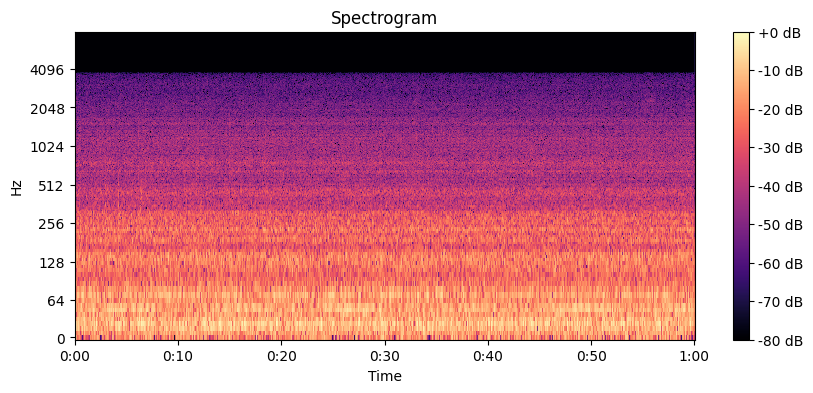

In [ ]:
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from collections import defaultdict
from IPython.display import Audio

data_path = r"C:\V89\data"  # แก้เป็น path dataset ของคุณ
bin_size_sec = 60           # ขนาด bin (1 นาที)

# อ่านทุก annotation + wav
all_bins = defaultdict(int)
files_map = {}  # map bin -> (filename, start_sec)

for ann_file in sorted(glob(os.path.join(data_path, "*_annotation.json"))):
    prefix = os.path.basename(ann_file).split('_')[0]
    wav_file = os.path.join(data_path, f"{prefix}_phone.wav")

    with open(ann_file, "r") as f:
        ann = json.load(f)

    for e in ann["events"]:
        # offset ในไฟล์เสียง = event_start - record_start
        start_in_audio = e["evnet_start"] - ann["record_start"]
        start_bin = int(start_in_audio // bin_size_sec)
        
        all_bins[(prefix, start_bin)] += 1
        files_map[(prefix, start_bin)] = wav_file


# หา bin ที่ event มากสุดและน้อยสุด (แต่ > 0)
max_bin = max(all_bins.items(), key=lambda x: x[1])
min_bin = min([b for b in all_bins.items() if b[1] > 0], key=lambda x: x[1])

print("Max bin:", max_bin, "Min bin:", min_bin)

def extract_and_plot(wav_file, bin_idx, sr_target=16000):
    start_sec = bin_idx * bin_size_sec
    y, sr = librosa.load(wav_file, sr=sr_target)
    
    start_sample = int(start_sec * sr)
    end_sample = int((start_sec + bin_size_sec) * sr)
    
    # ป้องกัน index เกิน
    if start_sample >= len(y):
        print(f"⚠ Segment start {start_sec}s เกินความยาวไฟล์ {len(y)/sr:.2f}s")
        return None
    if end_sample > len(y):
        end_sample = len(y)
    
    segment = y[start_sample:end_sample]
    
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(segment, sr=sr)
    plt.title(f"Waveform: {os.path.basename(wav_file)} [{start_sec}-{start_sec+bin_size_sec}s]")
    plt.show()

    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(segment)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    plt.show()

    return Audio(segment, rate=sr)


# แสดง bin event หนาแน่นที่สุด
print("\n=== High density segment ===")
audio_max = extract_and_plot(files_map[max_bin[0]], max_bin[0][1])
display(audio_max)

# แสดง bin event ต่ำที่สุด
print("\n=== Low density segment ===")
audio_min = extract_and_plot(files_map[min_bin[0]], min_bin[0][1])
display(audio_min)


# Example sound of 2 class

Patient 01 | Label: hypo | Start: 6434.00s | Duration: 41.00s


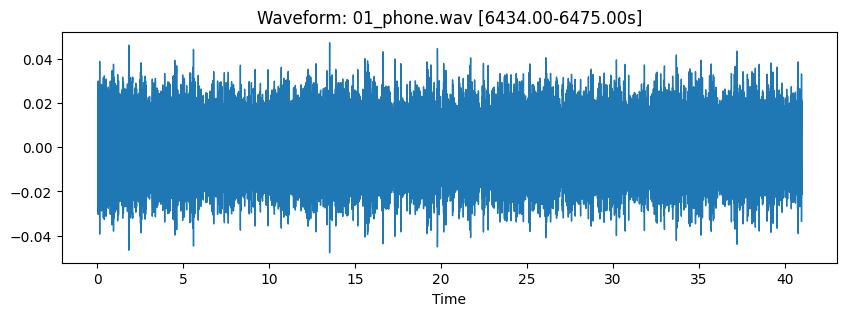

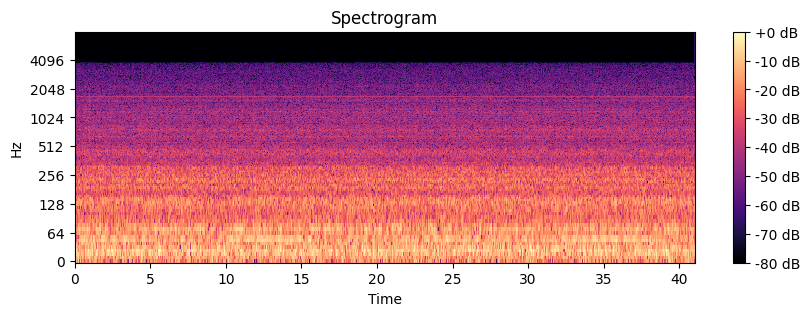

Patient 02 | Label: osa | Start: 1304.00s | Duration: 18.80s


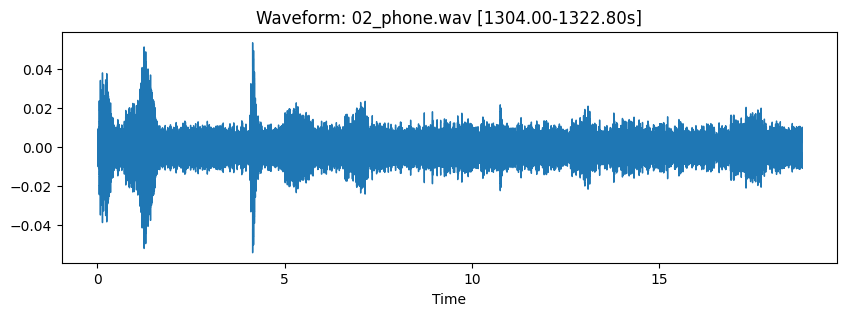

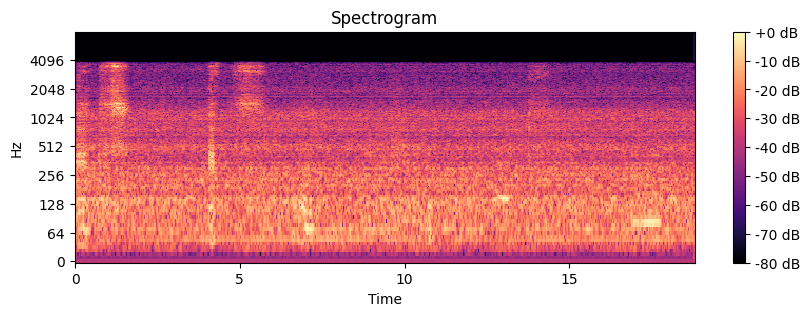

In [ ]:
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from IPython.display import Audio

data_path = r"C:\V89\data"  # path dataset
target_labels = ["osa", "hypo"]  # label ที่ต้องการฟัง
sr_target = 16000

def plot_and_play(wav_file, start_sec, duration_sec, sr_target=16000):
    y, sr = librosa.load(wav_file, sr=sr_target)
    start_sample = int(start_sec * sr)
    end_sample = int((start_sec + duration_sec) * sr)
    segment = y[start_sample:end_sample]

    # Waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(segment, sr=sr)
    plt.title(f"Waveform: {os.path.basename(wav_file)} [{start_sec:.2f}-{start_sec+duration_sec:.2f}s]")
    plt.show()

    # Spectrogram
    plt.figure(figsize=(10, 3))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(segment)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    plt.show()

    return Audio(segment, rate=sr)

# หาตัวอย่าง event
for ann_file in sorted(glob(os.path.join(data_path, "*_annotation.json"))):
    prefix = os.path.basename(ann_file).split('_')[0]
    wav_file = os.path.join(data_path, f"{prefix}_phone.wav")

    if not os.path.exists(wav_file):
        continue

    with open(ann_file, "r") as f:
        ann = json.load(f)

    record_start = ann["record_start"]

    for e in ann["events"]:
        if e["event_type"] in target_labels:
            start_in_audio = e["evnet_start"] - record_start
            duration = e["event_duration"]

            print(f"Patient {prefix} | Label: {e['event_type']} | Start: {start_in_audio:.2f}s | Duration: {duration:.2f}s")
            audio_player = plot_and_play(wav_file, start_in_audio, duration, sr_target)
            display(audio_player)

            # ถ้าอยากได้แค่ตัวอย่างแรกของแต่ละ label ให้ break ออก
            target_labels.remove(e["event_type"])
            break

    if not target_labels:  # ถ้าเจอครบทุก label แล้วก็หยุด
        break


# Example of all sound that have annotation
### It not/low different between hypo and none_sound

In [ ]:
# import os
# import json
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np
# from glob import glob
# from IPython.display import Audio

# data_path = r"C:\V89\data"  # path dataset
# target_labels = ["osa", "hypo"]  # label ที่ต้องการฟัง
# events_per_label_per_patient = 2  # จำนวน event ต่อ label ต่อ patient
# min_duration_sec = 5  # ตัด event สั้นมากทิ้ง
# sr_target = 16000

# def plot_and_play(wav_file, start_sec, duration_sec, sr_target=16000):
#     y, sr = librosa.load(wav_file, sr=sr_target)
#     start_sample = int(start_sec * sr)
#     end_sample = int((start_sec + duration_sec) * sr)
#     if start_sample >= len(y):
#         return None
#     if end_sample > len(y):
#         end_sample = len(y)
#     segment = y[start_sample:end_sample]

#     # Waveform
#     plt.figure(figsize=(10, 3))
#     librosa.display.waveshow(segment, sr=sr)
#     plt.title(f"{os.path.basename(wav_file)} [{start_sec:.2f}-{start_sec+duration_sec:.2f}s]")
#     plt.show()

#     # Spectrogram
#     plt.figure(figsize=(10, 3))
#     D = librosa.amplitude_to_db(np.abs(librosa.stft(segment)), ref=np.max)
#     librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title("Spectrogram")
#     plt.show()

#     return Audio(segment, rate=sr)

# # ลูปทุก patient
# for ann_file in sorted(glob(os.path.join(data_path, "*_annotation.json"))):
#     prefix = os.path.basename(ann_file).split('_')[0]
#     wav_file = os.path.join(data_path, f"{prefix}_phone.wav")

#     if not os.path.exists(wav_file):
#         continue

#     with open(ann_file, "r") as f:
#         ann = json.load(f)

#     record_start = ann["record_start"]

#     print(f"\n=== Patient {prefix} ===")
#     label_counts = {lbl: 0 for lbl in target_labels}

#     for e in ann["events"]:
#         if e["event_type"] in target_labels and e["event_duration"] >= min_duration_sec:
#             lbl = e["event_type"]
#             if label_counts[lbl] < events_per_label_per_patient:
#                 start_in_audio = e["evnet_start"] - record_start
#                 duration = e["event_duration"]

#                 print(f"Label: {lbl} | Start: {start_in_audio:.2f}s | Duration: {duration:.2f}s")
#                 audio_player = plot_and_play(wav_file, start_in_audio, duration, sr_target)
#                 if audio_player:
#                     display(audio_player)

#                 label_counts[lbl] += 1

#     # หยุดถ้าผู้ป่วยนี้ไม่มี label ที่ต้องการ
#     if all(c == 0 for c in label_counts.values()):
#         print("No target events found.")


In [24]:
import os
import librosa
import soundfile as sf
import noisereduce as nr
from tqdm import tqdm
import numpy as np

data_path = r"C:\V89\data"
output_path = os.path.join(data_path, "cleaned_fft")
os.makedirs(output_path, exist_ok=True)

patients = ["01", "02", "03"]
sr_target = 8000          # ลด sample rate
chunk_sec = 30            # ความยาว chunk (วินาที)

for pid in tqdm(patients, desc="Processing patients"):
    wav_file = os.path.join(data_path, f"{pid}_phone.wav")
    if not os.path.exists(wav_file):
        tqdm.write(f"Missing: {wav_file}")
        continue

    # โหลดและลด sample rate
    y, sr = librosa.load(wav_file, sr=sr_target)

    # ใช้ 1 วินาทีแรกเป็น noise profile
    noise_clip = y[0:sr]

    # เตรียมบันทึกผล
    cleaned_segments = []

    # ตัดเป็น chunks แล้วประมวลผล
    chunk_samples = chunk_sec * sr
    for start in range(0, len(y), chunk_samples):
        end = min(start + chunk_samples, len(y))
        chunk = y[start:end]
        if len(chunk) < 1:
            continue
        clean_chunk = nr.reduce_noise(y=chunk, sr=sr, y_noise=noise_clip, prop_decrease=1.0)
        cleaned_segments.append(clean_chunk)

    # รวมกลับเป็นคลิปเดียว
    y_clean = np.concatenate(cleaned_segments)

    # เซฟไฟล์ใหม่
    save_path = os.path.join(output_path, f"{pid}_phone_clean_fft.wav")
    sf.write(save_path, y_clean, sr)
    tqdm.write(f"Saved cleaned FFT: {save_path}")


Processing patients:  33%|███▎      | 1/3 [01:15<02:30, 75.03s/it]

Saved cleaned FFT: C:\V89\data\cleaned_fft\01_phone_clean_fft.wav


Processing patients:  67%|██████▋   | 2/3 [02:20<01:09, 69.20s/it]

Saved cleaned FFT: C:\V89\data\cleaned_fft\02_phone_clean_fft.wav


Processing patients: 100%|██████████| 3/3 [03:30<00:00, 70.13s/it]

Saved cleaned FFT: C:\V89\data\cleaned_fft\03_phone_clean_fft.wav


# FFT + Denoise
### ผลลัพธ์คอ่นข้าง กาก ถ้าเป็นในส่วนของ hypo แต่ osa ผลลพธ์ค่อนข้างดี

In [27]:
# import os
# import json
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np
# from IPython.display import Audio

# # Paths
# data_path = r"C:\V89\data"
# cleaned_path = os.path.join(data_path, "cleaned_fft")
# sr_target = 16000
# patients = ["01", "02", "03"]  # Patient IDs to compare

# def plot_waveform_and_spec(signal, sr, title):
#     # Plot waveform
#     plt.figure(figsize=(10, 3))
#     librosa.display.waveshow(signal, sr=sr)
#     plt.title(f"Waveform - {title}")
#     plt.show()
#     # Plot spectrogram
#     plt.figure(figsize=(10, 3))
#     D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
#     librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(f"Spectrogram - {title}")
#     plt.show()

# for pid in patients:
#     ann_file = os.path.join(data_path, f"{pid}_annotation.json")
#     wav_orig = os.path.join(data_path, f"{pid}_phone.wav")
#     wav_clean = os.path.join(cleaned_path, f"{pid}_phone_clean_fft.wav")

#     if not (os.path.exists(ann_file) and os.path.exists(wav_orig) and os.path.exists(wav_clean)):
#         print(f"Missing files for patient {pid}")
#         continue

#     with open(ann_file, "r") as f:
#         ann = json.load(f)

#     record_start = ann["record_start"]
#     y_orig, sr = librosa.load(wav_orig, sr=sr_target)
#     y_clean, _ = librosa.load(wav_clean, sr=sr_target)

#     print(f"\n=== Patient {pid} (OSA events only) ===")
#     for idx, e in enumerate(ann["events"], start=1):
#         if e["event_type"] != "osa":
#             continue  # Skip non-OSA events

#         start_in_audio = e["evnet_start"] - record_start
#         duration = e["event_duration"]

#         start_sample = int(start_in_audio * sr)
#         end_sample = int((start_in_audio + duration) * sr)
#         seg_orig = y_orig[start_sample:end_sample]
#         seg_clean = y_clean[start_sample:end_sample]

#         label = e["event_type"]
#         print(f"OSA Event {idx}: Start {start_in_audio:.2f}s | Duration {duration:.2f}s")

#         # Original
#         plot_waveform_and_spec(seg_orig, sr, f"Original - {label}")
#         display(Audio(seg_orig, rate=sr))

#         # Cleaned
#         plot_waveform_and_spec(seg_clean, sr, f"Cleaned (FFT) - {label}")
#         display(Audio(seg_clean, rate=sr))


# count all label in each patient

In [1]:
import os
import json
from collections import Counter
from glob import glob

# Path to your annotation files
data_path = r"C:\V89\data"
ann_files = glob(os.path.join(data_path, "*_annotation.json"))

label_counts = Counter()

for ann_file in ann_files:
    with open(ann_file, "r") as f:
        ann = json.load(f)
    for e in ann["events"]:
        label_counts[e["event_type"]] += 1

print("Label counts in all annotation files:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# If you want counts per patient
print("\nCounts per patient:")
for ann_file in ann_files:
    with open(ann_file, "r") as f:
        ann = json.load(f)
    counts = Counter([e["event_type"] for e in ann["events"]])
    pid = os.path.basename(ann_file).split('_')[0]
    print(f"Patient {pid} -> {dict(counts)}")


Label counts in all annotation files:
hypo: 2676
osa: 1636

Counts per patient:
Patient 01 -> {'hypo': 85, 'osa': 1}
Patient 02 -> {'hypo': 160, 'osa': 414}
Patient 03 -> {'hypo': 174, 'osa': 55}
Patient 04 -> {'hypo': 38}
Patient 05 -> {'hypo': 123, 'osa': 312}
Patient 06 -> {'hypo': 161, 'osa': 119}
Patient 07 -> {'osa': 6, 'hypo': 52}
Patient 08 -> {'hypo': 154, 'osa': 165}
Patient 09 -> {'hypo': 210, 'osa': 96}
Patient 10 -> {'hypo': 183, 'osa': 44}
Patient 12 -> {'hypo': 89}
Patient 13 -> {'hypo': 159, 'osa': 6}
Patient 14 -> {'hypo': 220}
Patient 15 -> {'hypo': 64, 'osa': 139}
Patient 16 -> {'hypo': 115, 'osa': 7}
Patient 18 -> {'hypo': 147, 'osa': 8}
Patient 19 -> {'hypo': 128, 'osa': 175}
Patient 20 -> {'hypo': 414, 'osa': 89}


In [2]:
import os
import json
from collections import Counter
from glob import glob

# Path to your annotation files
data_path = r"C:\V89\data\annotation_with_normal"
ann_files = glob(os.path.join(data_path, "*_annotation.json"))

label_counts = Counter()

for ann_file in ann_files:
    with open(ann_file, "r") as f:
        ann = json.load(f)
    for e in ann["events"]:
        label_counts[e["event_type"]] += 1

print("Label counts in all annotation files:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# If you want counts per patient
print("\nCounts per patient:")
for ann_file in ann_files:
    with open(ann_file, "r") as f:
        ann = json.load(f)
    counts = Counter([e["event_type"] for e in ann["events"]])
    pid = os.path.basename(ann_file).split('_')[0]
    print(f"Patient {pid} -> {dict(counts)}")


Label counts in all annotation files:
hypo: 2676
osa: 1636
normal: 4284

Counts per patient:
Patient 01 -> {'hypo': 85, 'osa': 1, 'normal': 86}
Patient 02 -> {'hypo': 160, 'osa': 414, 'normal': 574}
Patient 03 -> {'hypo': 174, 'osa': 55, 'normal': 228}
Patient 04 -> {'hypo': 38, 'normal': 38}
Patient 05 -> {'hypo': 123, 'osa': 312, 'normal': 431}
Patient 06 -> {'hypo': 161, 'osa': 119, 'normal': 273}
Patient 07 -> {'osa': 6, 'hypo': 52, 'normal': 58}
Patient 08 -> {'hypo': 154, 'osa': 165, 'normal': 317}
Patient 09 -> {'hypo': 210, 'osa': 96, 'normal': 305}
Patient 10 -> {'hypo': 183, 'osa': 44, 'normal': 227}
Patient 12 -> {'hypo': 89, 'normal': 88}
Patient 13 -> {'hypo': 159, 'osa': 6, 'normal': 165}
Patient 14 -> {'hypo': 220, 'normal': 220}
Patient 15 -> {'hypo': 64, 'osa': 139, 'normal': 203}
Patient 16 -> {'hypo': 115, 'osa': 7, 'normal': 119}
Patient 18 -> {'hypo': 147, 'osa': 8, 'normal': 149}
Patient 19 -> {'hypo': 128, 'osa': 175, 'normal': 303}
Patient 20 -> {'hypo': 414, 'o